In [ ]:
#Analyse √©conomique approfondie de Madagascar (1960-2023)
# --------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

In [ ]:
# Configuration des graphiques

plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Charger les donn√©es
# Note: Utilisez le chemin correct vers votre fichier
df = pd.read_csv('/content/taux_change_ar_usd - Copie.csv', sep=';')

In [ ]:
# Fonction pour ajouter des √©v√©nements historiques sur les graphiques
def ajouter_evenements_historiques(ax):
    evenements = {
        1960: "Ind√©pendance de Madagascar",
        1972: "Renversement de la Premi√®re R√©publique",
        1975: "Nationalisation sous Ratsiraka",
        1980: "Crise √©conomique/Plan d'ajustement structurel",
        1991: "Transition d√©mocratique",
        2002: "Crise politique post-√©lectorale",
        2009: "Coup d'√©tat/Crise politique",
        2013: "Retour √† l'ordre constitutionnel",
        2020: "Crise du COVID-19"
    }

    for annee, evenement in evenements.items():
        if annee in df['Year'].values:
            ax.axvline(x=annee, color='darkred', linestyle='--', alpha=0.5)
            ax.annotate(evenement, xy=(annee, ax.get_ylim()[1]*0.9),
                       xytext=(annee+1, ax.get_ylim()[1]*0.9), rotation=90,
                       fontsize=8, ha='left', va='top')

# P√©riodes de chocs exog√®nes majeurs
chocs_exogenes = {
    1973: "Premier choc p√©trolier",
    1979: "Deuxi√®me choc p√©trolier",
    1991: "Guerre du Golfe",
    2008: "Crise financi√®re mondiale",
    2011: "Crise de la dette europ√©enne",
    2020: "Pand√©mie de COVID-19",
    2022: "Guerre en Ukraine/Crise √©nerg√©tique"
}


In [ ]:
# Pr√©paration et nettoyage des donn√©es
# Conversion des colonnes en types num√©riques appropri√©s
for col in df.columns:
    if col != 'Year':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# D√©finir l'ann√©e comme index
df['Year'] = pd.to_numeric(df['Year'])
df_indexed = df.set_index('Year')

# V√©rifier les valeurs manquantes
print("Nombre de valeurs manquantes par colonne:")
print(df.isna().sum())

Nombre de valeurs manquantes par colonne:
Year                                                                                       0
Official exchange rate (LCU per US$, period average)                                       0
Inflation, consumer prices (annual %)                                                      5
Total reserves (includes gold, current US$)                                                2
Total reserves in months of imports                                                       15
Total reserves minus gold (current US$)                                                    2
Foreign direct investment, net inflows (% of GDP)                                         10
Foreign direct investment, net inflows (BoP, current US$)                                 10
Personal remittances, received (current US$)                                              14
GDP (current US$)                                                                          0
Lending interest rate (%)   

In [ ]:
# Calculer le pourcentage de valeurs manquantes par colonne
missing_percentage = (df.isna().sum() / len(df)) * 100
print("\nPourcentage de valeurs manquantes par colonne:")
print(missing_percentage)



Pourcentage de valeurs manquantes par colonne:
Year                                                                                       0.0000
Official exchange rate (LCU per US$, period average)                                       0.0000
Inflation, consumer prices (annual %)                                                      7.8125
Total reserves (includes gold, current US$)                                                3.1250
Total reserves in months of imports                                                       23.4375
Total reserves minus gold (current US$)                                                    3.1250
Foreign direct investment, net inflows (% of GDP)                                         15.6250
Foreign direct investment, net inflows (BoP, current US$)                                 15.6250
Personal remittances, received (current US$)                                              21.8750
GDP (current US$)                                                     

In [ ]:
# Statistiques descriptives g√©n√©rales
print("\nStatistiques descriptives:")
desc_stats = df.describe().T
desc_stats['cv'] = desc_stats['std'] / desc_stats['mean']  # Coefficient de variation
print(desc_stats)


Statistiques descriptives:
                                                    count          mean  \
Year                                                 64.0  1.991500e+03   
Official exchange rate (LCU per US$, period ave...   64.0  1.087125e+03   
Inflation, consumer prices (annual %)                59.0  1.114892e+01   
Total reserves (includes gold, current US$)          62.0  4.833036e+08   
Total reserves in months of imports                  49.0  2.350234e+00   
Total reserves minus gold (current US$)              62.0  4.833036e+08   
Foreign direct investment, net inflows (% of GDP)    54.0  2.106694e+00   
Foreign direct investment, net inflows (BoP, cu...   54.0  2.152810e+08   
Personal remittances, received (current US$)         50.0  1.333067e+08   
GDP (current US$)                                    64.0  5.604384e+09   
Lending interest rate (%)                            35.0  3.916928e+01   
External debt stocks, total (DOD, current US$)       54.0  2.988430e+09 

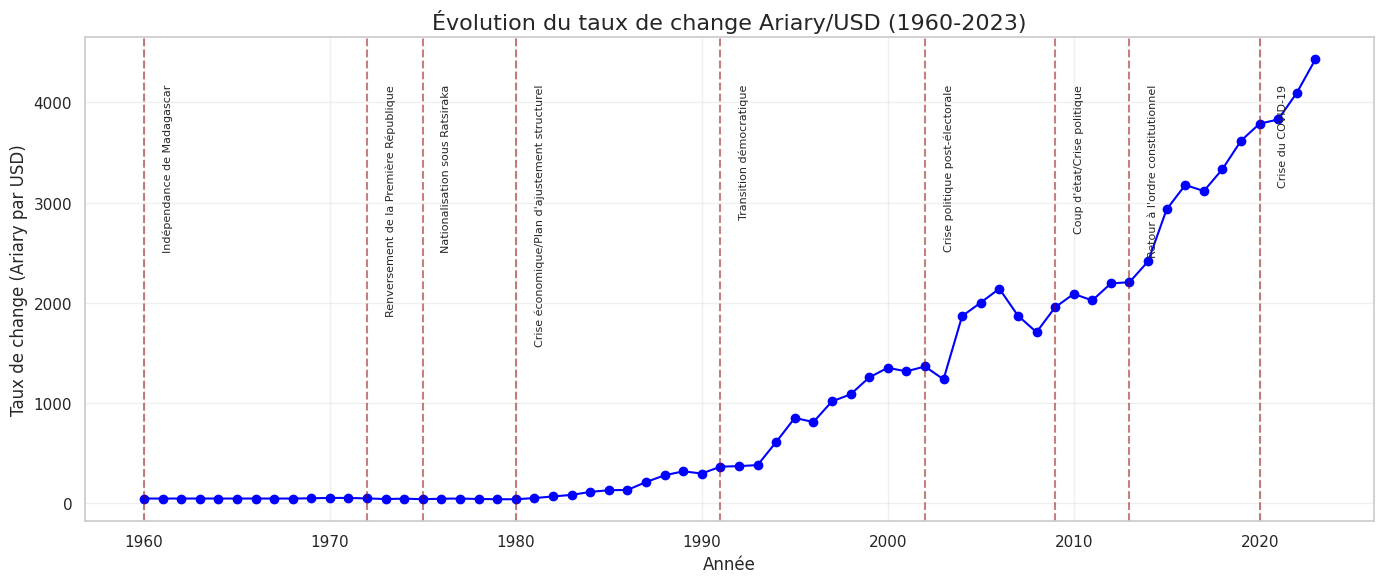

In [ ]:
#PARTIE 2: ANALYSE DESCRIPTIVE DES INDICATEURS √âCONOMIQUES PRINCIPAUX
#Analyse de l'√©volution du taux de change
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Official exchange rate (LCU per US$, period average)'], marker='o', linestyle='-', color='blue')
plt.title('√âvolution du taux de change Ariary/USD (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Taux de change (Ariary par USD)', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

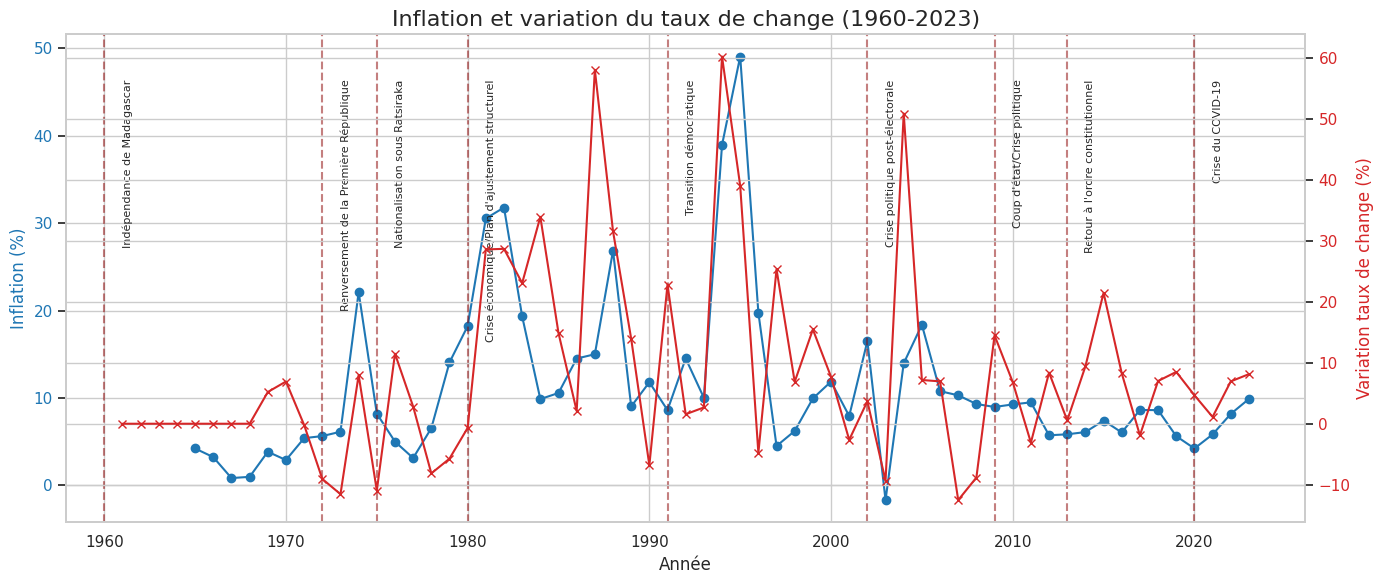

In [ ]:
# Calculer les variations annuelles du taux de change
df['Variation taux de change (%)'] = df['Official exchange rate (LCU per US$, period average)'].pct_change() * 100

# Analyse de l'inflation et sa relation avec le taux de change
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Ann√©e', fontsize=12)
ax1.set_ylabel('Inflation (%)', color=color, fontsize=12)
ax1.plot(df['Year'], df['Inflation, consumer prices (annual %)'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Variation taux de change (%)', color=color, fontsize=12)
ax2.plot(df['Year'], df['Variation taux de change (%)'], color=color, marker='x', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Inflation et variation du taux de change (1960-2023)', fontsize=16)
ajouter_evenements_historiques(ax1)
fig.tight_layout()


In [ ]:
##Calculer la corr√©lation entre l'inflation et la variation du taux de change
inflation_exchange_corr = df['Inflation, consumer prices (annual %)'].corr(df['Variation taux de change (%)'])
print(f"\nCorr√©lation entre inflation et variation du taux de change: {inflation_exchange_corr:.4f}")



Corr√©lation entre inflation et variation du taux de change: 0.5645


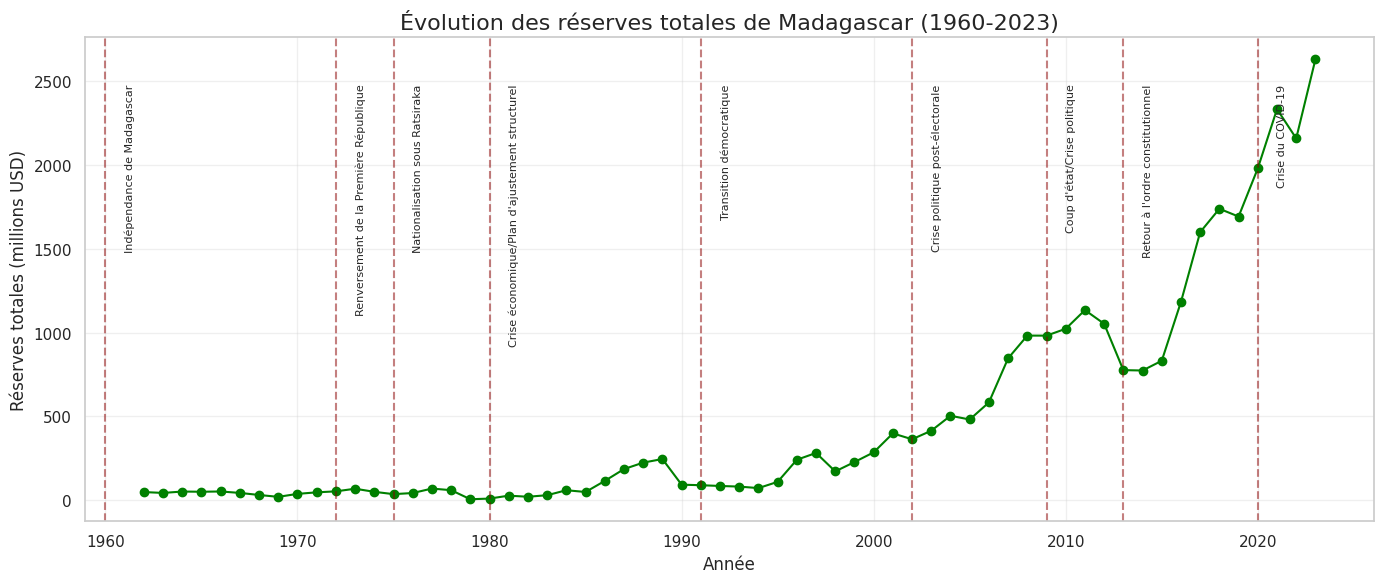

In [ ]:
# Analyse des r√©serves et de leur impact sur l'√©conomie
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Total reserves (includes gold, current US$)'] / 1e6, marker='o', linestyle='-', color='green')
plt.title('√âvolution des r√©serves totales de Madagascar (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('R√©serves totales (millions USD)', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()


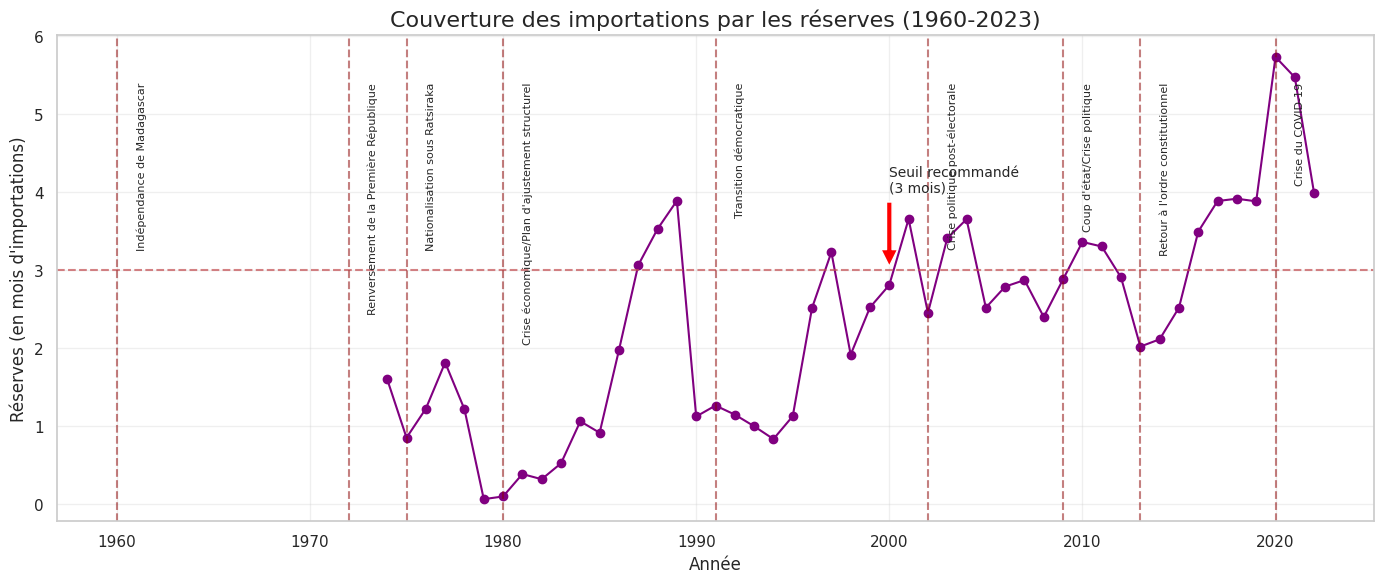

In [ ]:
# Analyser la relation entre les r√©serves et les importations
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Total reserves in months of imports'], marker='o', linestyle='-', color='purple')
plt.title('Couverture des importations par les r√©serves (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('R√©serves (en mois d\'importations)', fontsize=12)
plt.axhline(y=3, color='r', linestyle='--', alpha=0.7)  # Standard international recommand√©
plt.annotate('Seuil recommand√©\n(3 mois)', xy=(2000, 3), xytext=(2000, 4),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()


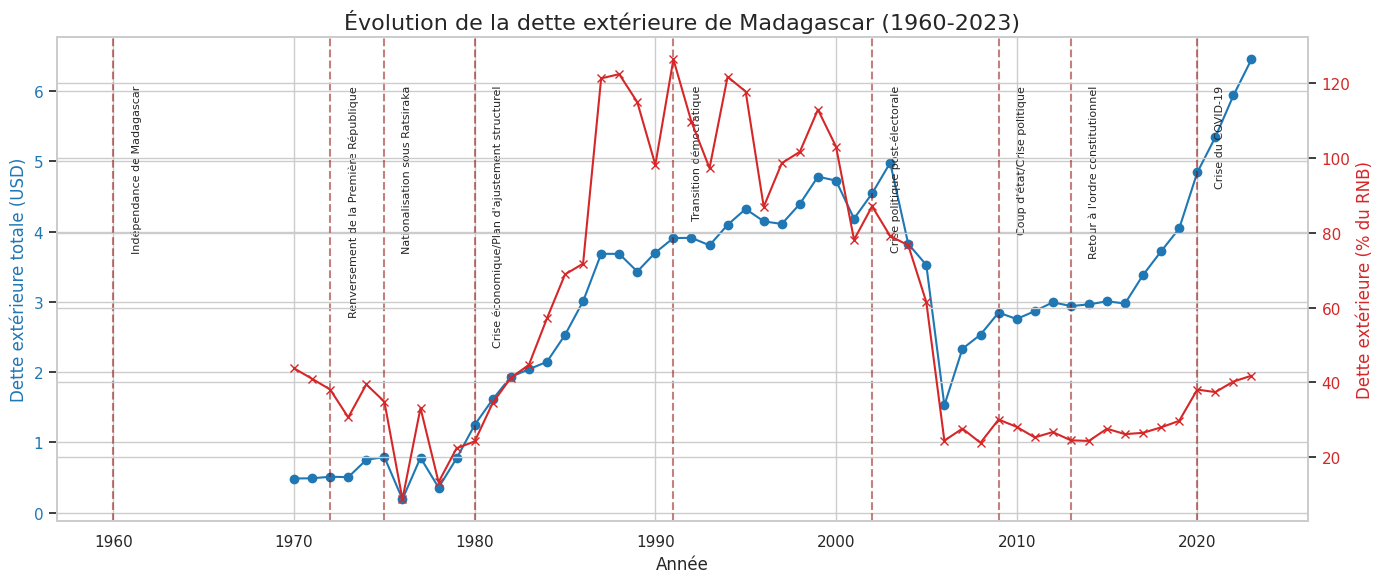

In [ ]:

# Analyse de la dette ext√©rieure
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Ann√©e', fontsize=12)
ax1.set_ylabel('Dette ext√©rieure totale (USD)', color=color, fontsize=12)
ax1.plot(df['Year'], df['External debt stocks, total (DOD, current US$)'] / 1e9, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Dette ext√©rieure (% du RNB)', color=color, fontsize=12)
ax2.plot(df['Year'], df['External debt stocks (% of GNI)'], color=color, marker='x', linestyle='-')  #PIB + revenus nets re√ßus de l‚Äô√©tranger ==>(RNB = richesses cr√©√©es + revenus re√ßus de l‚Äô√©tranger).
ax2.tick_params(axis='y', labelcolor=color)

plt.title('√âvolution de la dette ext√©rieure de Madagascar (1960-2023)', fontsize=16)
ajouter_evenements_historiques(ax1)
fig.tight_layout()


In [ ]:
# Analyse de la balance commerciale
# Calculer la balance commerciale
df['Balance commerciale (USD)'] = df['Exports of goods and services (current US$)'] - df['Imports of goods and services (current US$)']
df['Balance commerciale (% PIB)'] = df['Balance commerciale (USD)'] / df['GDP (current US$)'] * 100


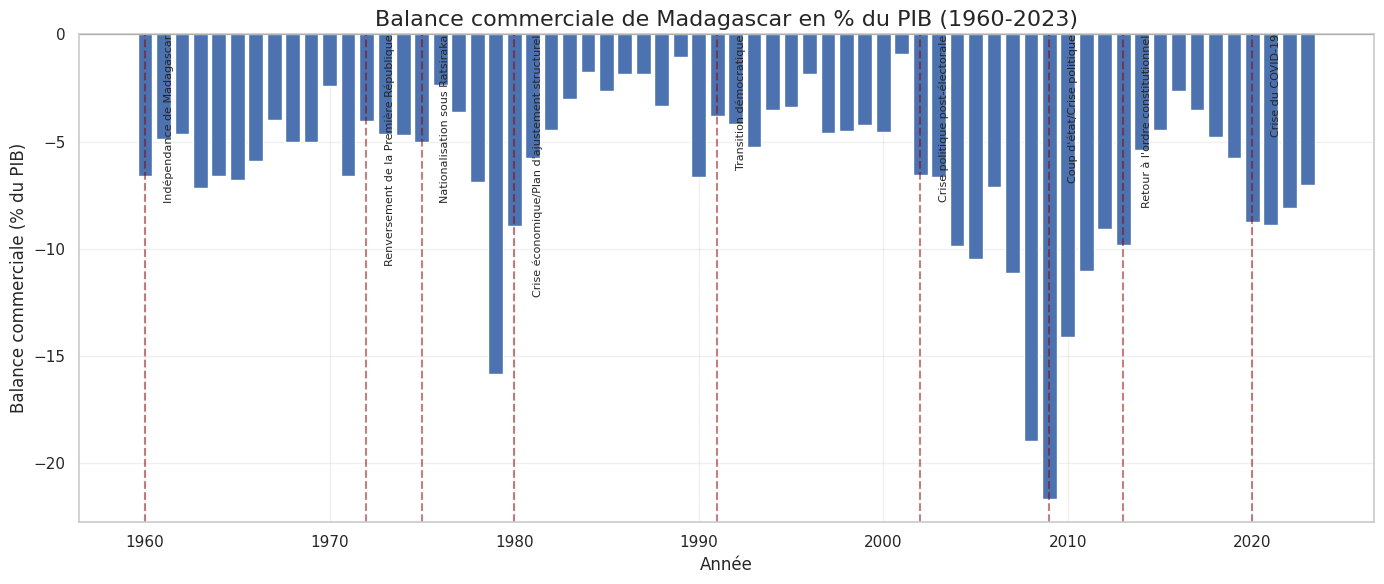

In [ ]:
# Graphique de la balance commerciale
plt.figure(figsize=(14, 6))
plt.bar(df['Year'], df['Balance commerciale (% PIB)'])
plt.title('Balance commerciale de Madagascar en % du PIB (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Balance commerciale (% du PIB)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-')
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()


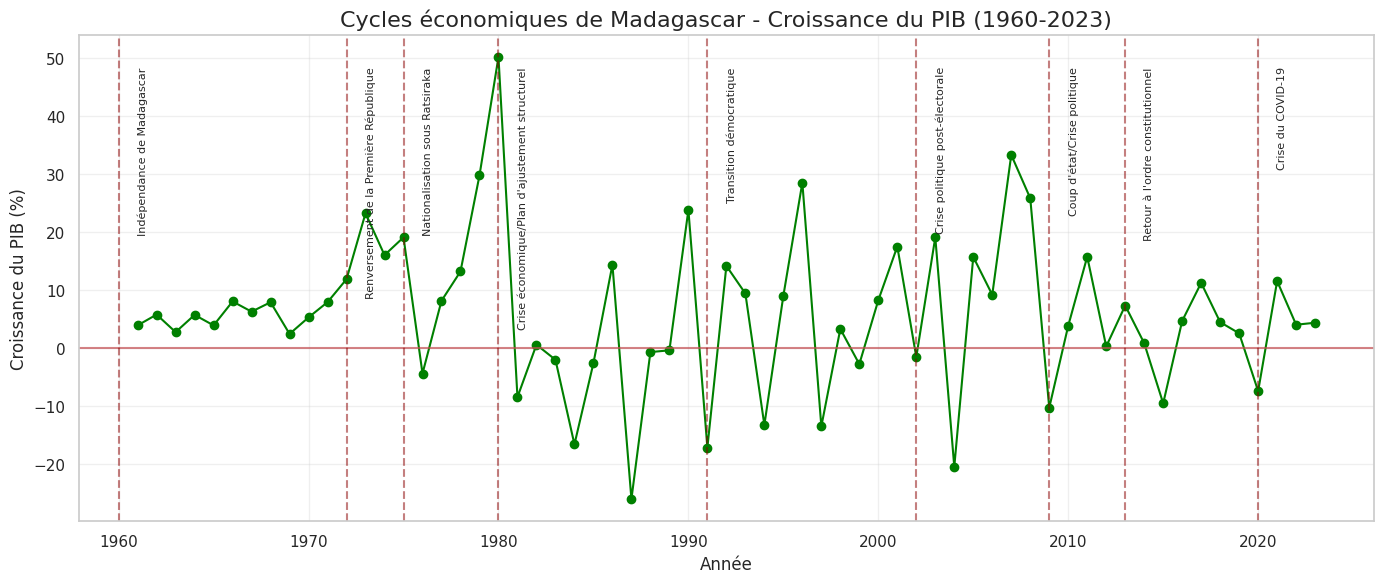

In [ ]:

# Cycles √©conomiques
# Identification des cycles √©conomiques √† partir du PIB
df['PIB_croissance'] = df['GDP (current US$)'].pct_change() * 100

plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['PIB_croissance'], marker='o', linestyle='-', color='green')
plt.title('Cycles √©conomiques de Madagascar - Croissance du PIB (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Croissance du PIB (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.7)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

In [ ]:
# Analyse multivari√©e: facteurs d√©terminants du taux de change
# S√©lectionner les variables potentiellement explicatives
explanatory_vars = ['Inflation, consumer prices (annual %)',
                    'Total reserves (includes gold, current US$)',
                    'Foreign direct investment, net inflows (% of GDP)',
                    'External debt stocks (% of GNI)',
                    'Balance commerciale (% PIB)']


In [ ]:
# Pr√©parer les donn√©es en supprimant les valeurs manquantes
model_data = df[['Year', 'Official exchange rate (LCU per US$, period average)'] + explanatory_vars].dropna()

# Cr√©er des variables d√©cal√©es pour tenir compte des effets retard√©s
for var in explanatory_vars:
    model_data[f"{var}_lag1"] = model_data[var].shift(1)

model_data = model_data.dropna()

# Mod√®le de r√©gression multiple
X = model_data[[col for col in model_data.columns if col not in ['Year', 'Official exchange rate (LCU per US$, period average)']]]
y = model_data['Official exchange rate (LCU per US$, period average)']

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print("\nR√©sultats de la r√©gression multiple pour le taux de change:")
print(results.summary())


R√©sultats de la r√©gression multiple pour le taux de change:
                                             OLS Regression Results                                             
Dep. Variable:     Official exchange rate (LCU per US$, period average)   R-squared:                       0.915
Model:                                                              OLS   Adj. R-squared:                  0.895
Method:                                                   Least Squares   F-statistic:                     45.15
Date:                                                  Fri, 25 Apr 2025   Prob (F-statistic):           3.05e-19
Time:                                                          11:18:48   Log-Likelihood:                -389.41
No. Observations:                                                    53   AIC:                             800.8
Df Residuals:                                                        42   BIC:                             822.5
Df Model:                        

In [ ]:
# Analyse en composantes principales (ACP)
# S√©lectionner les variables √©conomiques cl√©s
key_vars = ['Official exchange rate (LCU per US$, period average)',
            'Inflation, consumer prices (annual %)',
            'Total reserves (includes gold, current US$)',
            'External debt stocks (% of GNI)',
            'Foreign direct investment, net inflows (% of GDP)',
            'Balance commerciale (% PIB)']

pca_data = df[key_vars].dropna()


In [ ]:
# Standardisation des donn√©es
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)


In [ ]:
# Calculer les composantes principales avec statsmodels
pca = sm.PCA(pca_data_scaled)
print("\nR√©sultats de l'ACP:")
print(f"Variance expliqu√©e par composante: {pca.eigenvals / sum(pca.eigenvals)}")
print("Loadings (coefficients des variables originales):")
print(pd.DataFrame(pca.loadings, index=key_vars))



R√©sultats de l'ACP:
Variance expliqu√©e par composante: [0.52425473 0.17697624 0.15850551 0.09173324 0.04022692 0.00830336]
Loadings (coefficients des variables originales):
                                                           0         1  \
Official exchange rate (LCU per US$, period ave...  0.465641 -0.468122   
Inflation, consumer prices (annual %)              -0.264216  0.187939   
Total reserves (includes gold, current US$)         0.476210 -0.444520   
External debt stocks (% of GNI)                    -0.360111 -0.267407   
Foreign direct investment, net inflows (% of GDP)   0.461591  0.333015   
Balance commerciale (% PIB)                        -0.379271 -0.604597   

                                                           2         3  \
Official exchange rate (LCU per US$, period ave... -0.247297 -0.045915   
Inflation, consumer prices (annual %)              -0.793319 -0.509700   
Total reserves (includes gold, current US$)        -0.203863 -0.110401   
External 

In [ ]:
# Clustering: identifier les p√©riodes √©conomiques similaires
# Donn√©es pour clustering
cluster_data = df[['Inflation, consumer prices (annual %)',
                   'Foreign direct investment, net inflows (% of GDP)',
                   'External debt stocks (% of GNI)',
                   'Balance commerciale (% PIB)']].dropna()

# Standardisation
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)


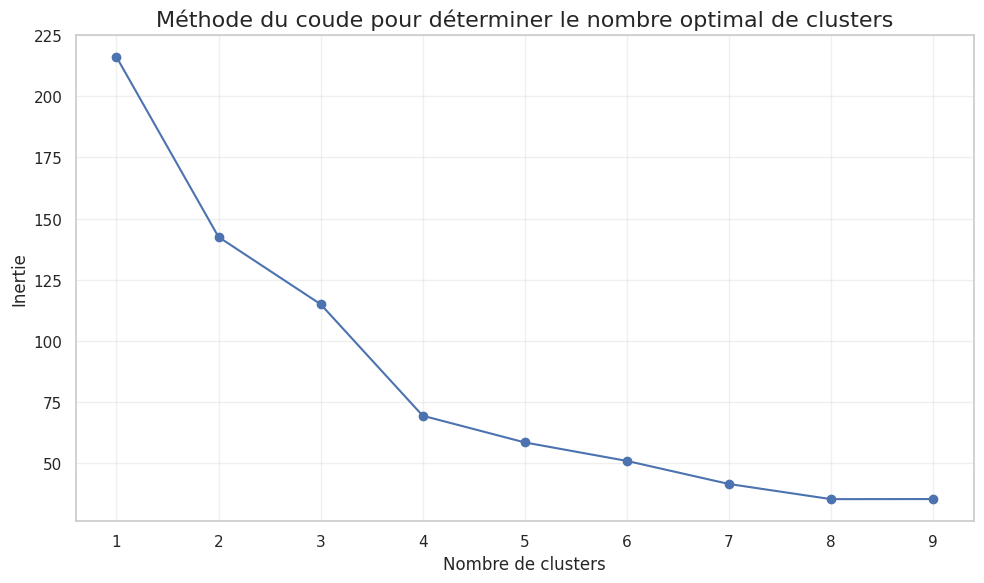

In [ ]:
# D√©terminer le nombre optimal de clusters (m√©thode du coude)
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertia.append(kmeans.inertia_)

# Graphique de la m√©thode du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('M√©thode du coude pour d√©terminer le nombre optimal de clusters', fontsize=16)
plt.xlabel('Nombre de clusters', fontsize=12)
plt.ylabel('Inertie', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()


In [ ]:
# Application du clustering avec k=4
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)

# Ajouter les labels de cluster aux donn√©es originales
cluster_years = df.loc[cluster_data.index, 'Year'].values
cluster_result = pd.DataFrame({'Year': cluster_years, 'Cluster': cluster_labels})
print("\nClassification des p√©riodes √©conomiques par cluster:")
print(cluster_result.sort_values('Year'))



Classification des p√©riodes √©conomiques par cluster:
    Year  Cluster
0   1970        1
1   1971        1
2   1972        1
3   1973        1
4   1974        2
5   1975        1
6   1976        1
7   1977        1
8   1978        1
9   1979        1
10  1980        1
11  1981        2
12  1982        2
13  1983        2
14  1984        0
15  1985        0
16  1986        0
17  1987        0
18  1988        2
19  1989        0
20  1990        0
21  1991        0
22  1992        0
23  1993        0
24  1994        2
25  1995        2
26  1996        0
27  1997        0
28  1998        0
29  1999        0
30  2000        0
31  2001        0
32  2002        0
33  2003        0
34  2004        0
35  2005        1
36  2006        1
37  2007        3
38  2008        3
39  2009        3
40  2010        3
41  2011        3
42  2012        3
43  2013        1
44  2014        1
45  2015        1
46  2016        1
47  2017        1
48  2018        1
49  2019        1
50  2020        1
51  2021


P√©riodes de crise √©conomique potentielle (forte volatilit√© du taux de change):
    Year  Volatilit√© taux de change
45  2005                 350.473209
46  2006                 399.242077
47  2007                 346.723962
55  2015                 351.643233
56  2016                 445.930209
57  2017                 434.460790
58  2018                 354.772927


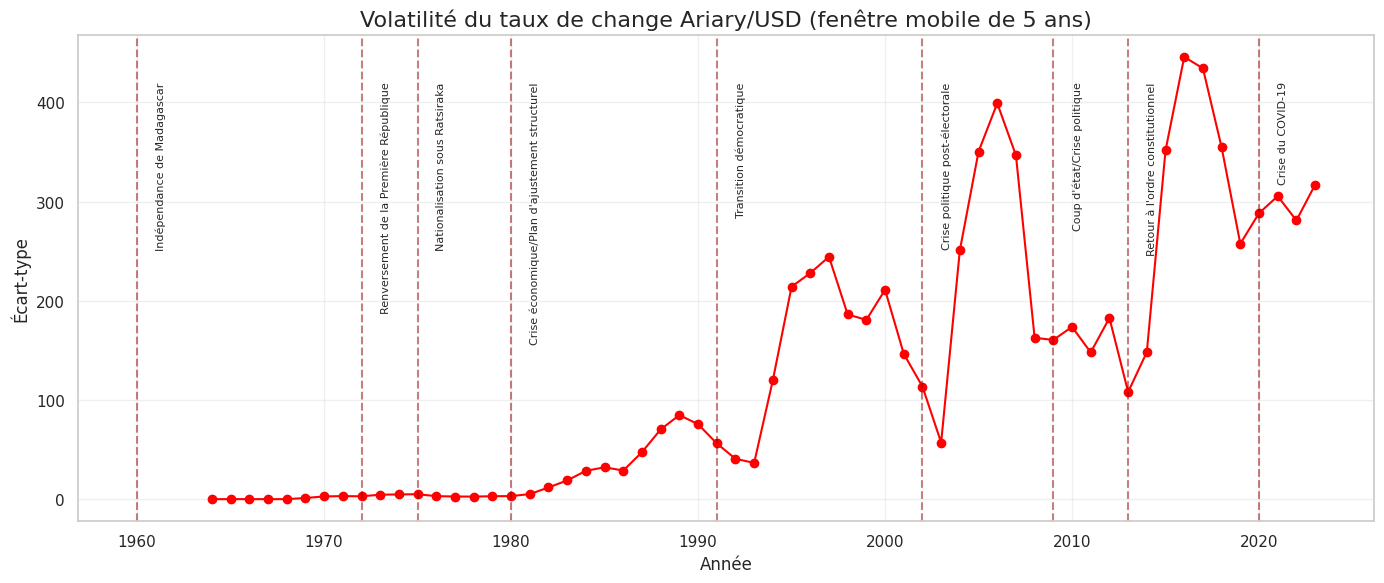

In [ ]:
# PARTIE 4: ANALYSES TH√âMATIQUES SP√âCIFIQUES
# ==========================================

# Analyse des crises √©conomiques et p√©riodes de stabilit√©
# Calcul de la volatilit√© du taux de change (√©cart-type mobile sur 5 ans)
df['Volatilit√© taux de change'] = df['Official exchange rate (LCU per US$, period average)'].rolling(window=5).std()

# Graphique de la volatilit√©
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Volatilit√© taux de change'], marker='o', linestyle='-', color='red')
plt.title('Volatilit√© du taux de change Ariary/USD (fen√™tre mobile de 5 ans)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('√âcart-type', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

# Identifier les p√©riodes de crise (forte volatilit√©) +-2
volatility_threshold = df['Volatilit√© taux de change'].mean() + 1.5 * df['Volatilit√© taux de change'].std()
crisis_periods = df[df['Volatilit√© taux de change'] > volatility_threshold]

print("\nP√©riodes de crise √©conomique potentielle (forte volatilit√© du taux de change):")
print(crisis_periods[['Year', 'Volatilit√© taux de change']])

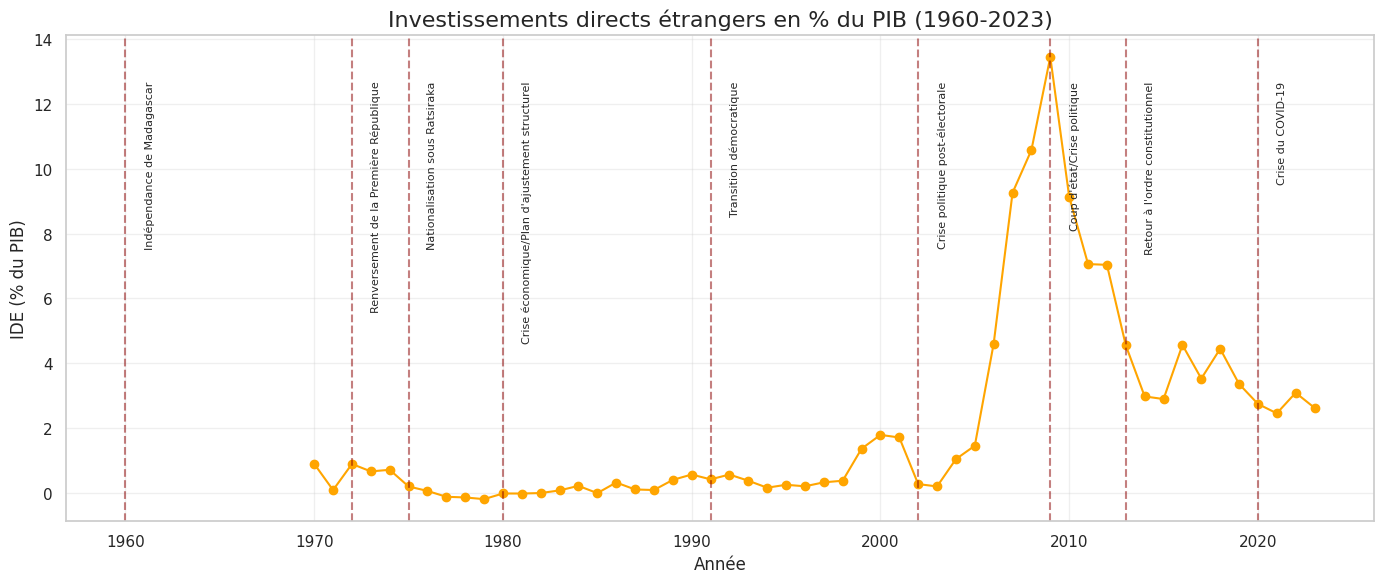

In [ ]:
# Analyse de l'impact des investissements directs √©trangers (IDE)
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Foreign direct investment, net inflows (% of GDP)'], marker='o', linestyle='-', color='orange')
plt.title('Investissements directs √©trangers en % du PIB (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('IDE (% du PIB)', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

In [ ]:
# Corr√©lation entre IDE et PIB
ide_gdp_corr = df['Foreign direct investment, net inflows (% of GDP)'].corr(df['GDP (current US$)'])
print(f"\nCorr√©lation entre IDE (% du PIB) et PIB: {ide_gdp_corr:.4f}")



Corr√©lation entre IDE (% du PIB) et PIB: 0.6115


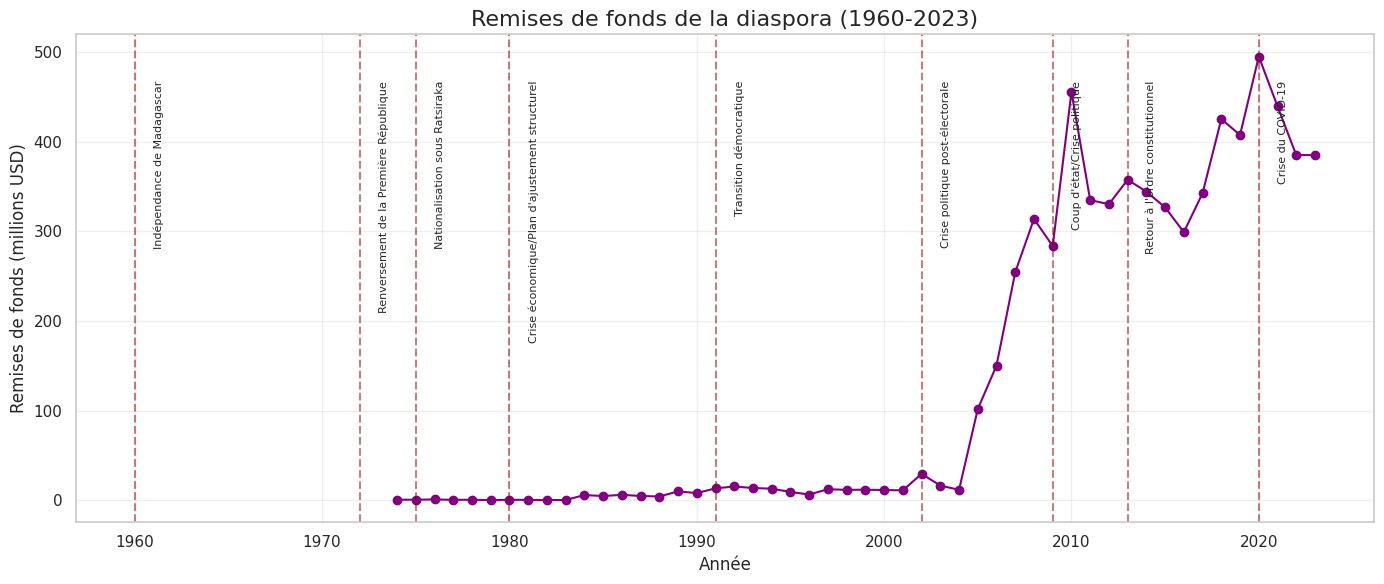

In [ ]:
# Analyse de l'impact des remises de fonds de la diaspora
plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Personal remittances, received (current US$)'] / 1e6,
         marker='o', linestyle='-', color='purple')
plt.title('Remises de fonds de la diaspora (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Remises de fonds (millions USD)', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

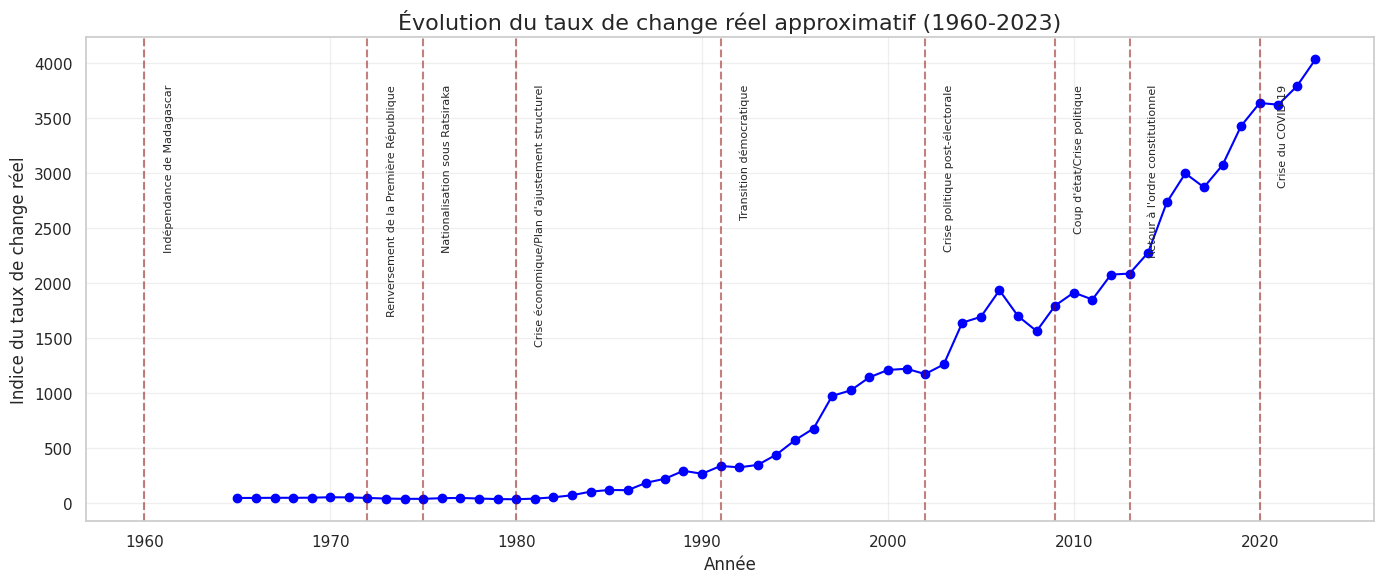

In [ ]:
# Calculer le ratio remises/PIB
df['Remises_PIB'] = df['Personal remittances, received (current US$)'] / df['GDP (current US$)'] * 100

# Analyse de la comp√©titivit√© et la relation avec le taux de change r√©el
# Calcul d'un indice approximatif du taux de change r√©el
df['Taux_change_reel'] = df['Official exchange rate (LCU per US$, period average)'] * \
                        (100 / (100 + df['Inflation, consumer prices (annual %)']))

plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['Taux_change_reel'], marker='o', linestyle='-', color='blue')
plt.title('√âvolution du taux de change r√©el approximatif (1960-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Indice du taux de change r√©el', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

In [ ]:
# Analyse des chocs exog√®nes et leur impact
# Cr√©er une variable indicatrice pour les p√©riodes de choc
df['Choc_exogene'] = 0
for annee in chocs_exogenes.keys():
    if annee in df['Year'].values:
        idx = df[df['Year'] == annee].index
        df.loc[idx, 'Choc_exogene'] = 1

# Analyser l'impact des chocs sur les principales variables
variables_impact = ['Inflation, consumer prices (annual %)',
                   'Official exchange rate (LCU per US$, period average)',
                   'Balance commerciale (% PIB)']

# Comparaison des p√©riodes avec/sans chocs
for var in variables_impact:
    avec_choc = df[df['Choc_exogene'] == 1][var].mean()
    sans_choc = df[df['Choc_exogene'] == 0][var].mean()
    print(f"Impact des chocs exog√®nes sur {var}: Moyenne avec choc = {avec_choc:.2f}, sans choc = {sans_choc:.2f}")


Impact des chocs exog√®nes sur Inflation, consumer prices (annual %): Moyenne avec choc = 8.56, sans choc = 11.50
Impact des chocs exog√®nes sur Official exchange rate (LCU per US$, period average): Moyenne avec choc = 1724.51, sans choc = 1008.85
Impact des chocs exog√®nes sur Balance commerciale (% PIB): Moyenne avec choc = -10.15, sans choc = -5.60


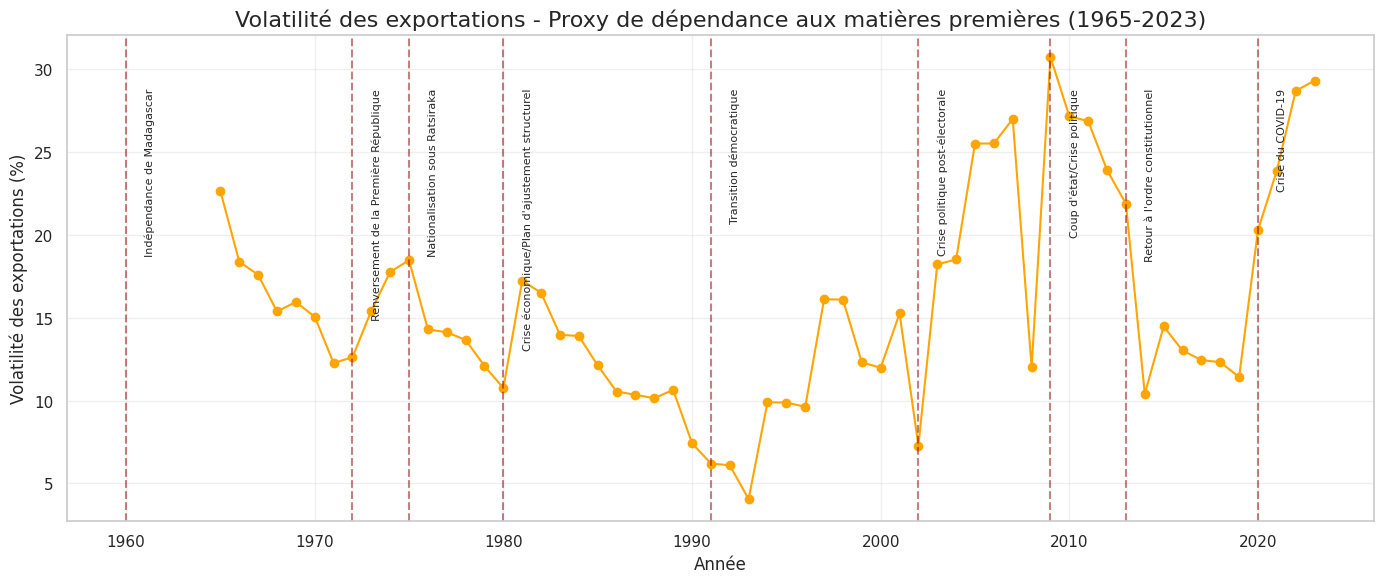

In [ ]:

# Analyse de la d√©pendance aux mati√®res premi√®res
# Cette partie n√©cessiterait des donn√©es suppl√©mentaires sur la structure des exportations
# Mais nous pouvons cr√©er un proxy en analysant la volatilit√© des exportations
df['Volatilite_exports'] = df['Exports of goods and services (current US$)'].pct_change().rolling(window=5).std() * 100

plt.figure(figsize=(14, 6))
plt.plot(df['Year'][5:], df['Volatilite_exports'][5:], marker='o', linestyle='-', color='orange')
plt.title('Volatilit√© des exportations - Proxy de d√©pendance aux mati√®res premi√®res (1965-2023)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Volatilit√© des exportations (%)', fontsize=12)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ajouter_evenements_historiques(ax)
plt.tight_layout()

In [ ]:


# PARTIE 5: SYNTH√àSE ET RECOMMANDATIONS
# ====================================

print("\n=== RAPPORT D'ANALYSE √âCONOMIQUE - MADAGASCAR (1960-2023) ===")
print("\nPrincipales observations:")

# Tendances du taux de change
avg_change_last_5_years = df.iloc[-5:]['Variation taux de change (%)'].mean()
print(f"1. √âvolution du taux de change: moyenne des variations sur les 5 derni√®res ann√©es = {avg_change_last_5_years:.2f}%")

# Inflation
avg_inflation_last_5_years = df.iloc[-5:]['Inflation, consumer prices (annual %)'].mean()
print(f"2. Inflation moyenne sur les 5 derni√®res ann√©es = {avg_inflation_last_5_years:.2f}%")

# R√©serves
avg_reserves_last_5_years = df.iloc[-5:]['Total reserves in months of imports'].mean()
print(f"3. Couverture moyenne des importations par les r√©serves (5 derni√®res ann√©es) = {avg_reserves_last_5_years:.2f} mois")

# Dette
avg_debt_last_5_years = df.iloc[-5:]['External debt stocks (% of GNI)'].mean()
print(f"4. Dette ext√©rieure moyenne (% du RNB, 5 derni√®res ann√©es) = {avg_debt_last_5_years:.2f}%")

# Balance commerciale
avg_trade_balance_last_5_years = df.iloc[-5:]['Balance commerciale (% PIB)'].mean()
print(f"5. Balance commerciale moyenne (% du PIB, 5 derni√®res ann√©es) = {avg_trade_balance_last_5_years:.2f}%")

print("\nVULN√âRABILIT√âS √âCONOMIQUES STRUCTURELLES:")
print("1. D√©pendance aux exportations agricoles (vanille, girofle, caf√©)")
print("2. Exposition aux catastrophes naturelles (cyclones, s√©cheresses)")
print("3. Faiblesse des infrastructures limitant la comp√©titivit√©")
print("4. Instabilit√© politique r√©currente affectant l'attractivit√© aux investissements")
print("5. Faible diversification √©conomique")

print("\nRECOMMANDATIONS √âCONOMIQUES D√âTAILL√âES:")
print("1. Politique mon√©taire:")
print("   - Maintenir une politique mon√©taire restrictive pour contenir l'inflation")
print("   - Intervenir de mani√®re cibl√©e sur le march√© des changes pour limiter la volatilit√©")
print("2. R√©serves internationales:")
print("   - Augmenter progressivement les r√©serves vers 6 mois d'importations")
print("   - Diversifier la composition des r√©serves pour r√©duire les risques")
print("3. Investissements directs √©trangers:")
print("   - Simplifier les proc√©dures administratives pour les investisseurs")
print("   - D√©velopper des zones √©conomiques sp√©ciales avec incitations fiscales")
print("4. Gestion de la dette:")
print("   - Privil√©gier les pr√™ts concessionnels et allonger les maturit√©s")
print("   - Limiter les nouvelles dettes commerciales √† taux √©lev√©s")
print("5. Commerce ext√©rieur:")
print("   - Investir dans la transformation locale des produits d'exportation")
print("   - Soutenir la diversification des exportations vers des produits √† plus forte valeur ajout√©e")



=== RAPPORT D'ANALYSE √âCONOMIQUE - MADAGASCAR (1960-2023) ===

Principales observations:
1. √âvolution du taux de change: moyenne des variations sur les 5 derni√®res ann√©es = 5.88%
2. Inflation moyenne sur les 5 derni√®res ann√©es = 6.73%
3. Couverture moyenne des importations par les r√©serves (5 derni√®res ann√©es) = 4.77 mois
4. Dette ext√©rieure moyenne (% du RNB, 5 derni√®res ann√©es) = 37.43%
5. Balance commerciale moyenne (% du PIB, 5 derni√®res ann√©es) = -7.71%

VULN√âRABILIT√âS √âCONOMIQUES STRUCTURELLES:
1. D√©pendance aux exportations agricoles (vanille, girofle, caf√©)
2. Exposition aux catastrophes naturelles (cyclones, s√©cheresses)
3. Faiblesse des infrastructures limitant la comp√©titivit√©
4. Instabilit√© politique r√©currente affectant l'attractivit√© aux investissements
5. Faible diversification √©conomique

RECOMMANDATIONS √âCONOMIQUES D√âTAILL√âES:
1. Politique mon√©taire:
   - Maintenir une politique mon√©taire restrictive pour contenir l'inflation
   - Interv

Test ADF - p-value: 1.0000
S√©rie non stationnaire ‚û§ on applique une diff√©renciation


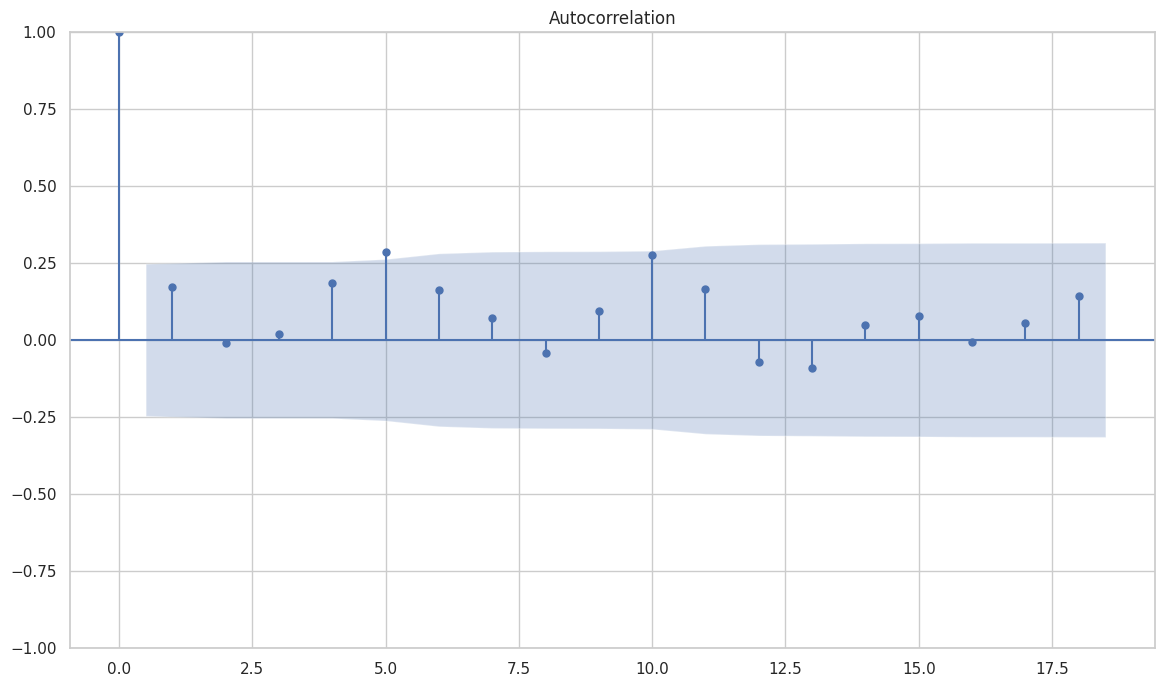

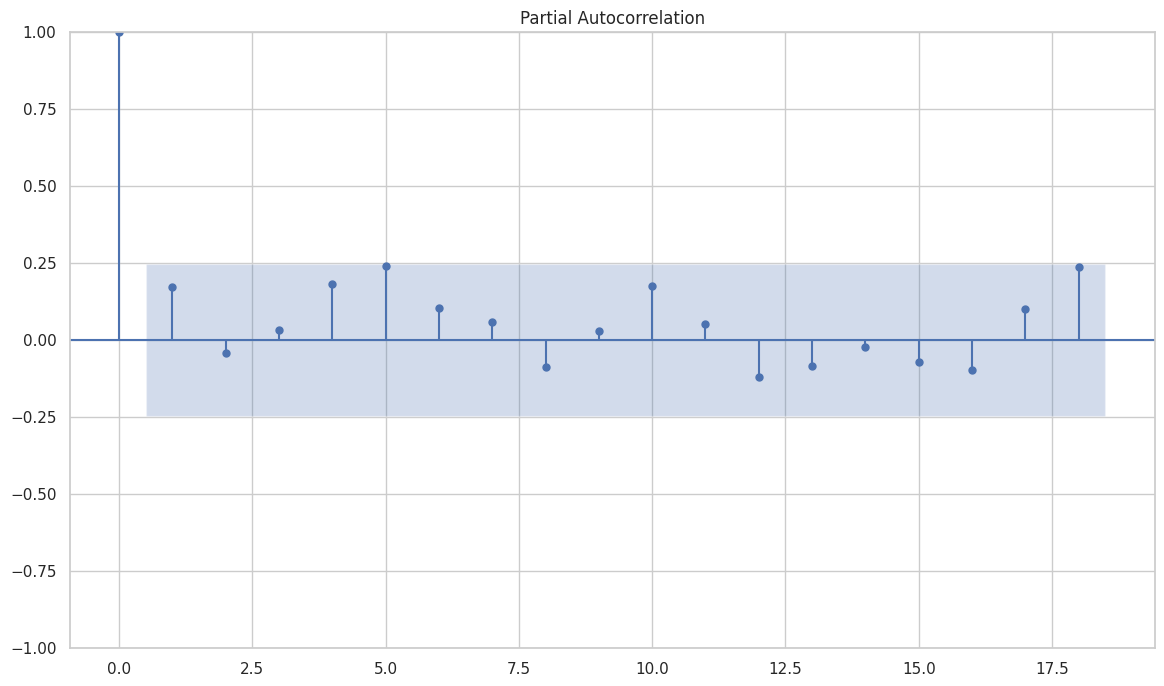

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                                                SARIMAX Results                                                 
Dep. Variable:     Official exchange rate (LCU per US$, period average)   No. Observations:                   64
Model:                                                   ARIMA(2, 1, 2)   Log Likelihood                -400.149
Date:                                                  Fri, 25 Apr 2025   AIC                            810.299
Time:                                                          11:18:50   BIC                            821.014
Sample:                                                               0   HQIC                           814.513
                                                                   - 64                                         
Covariance Type:                                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


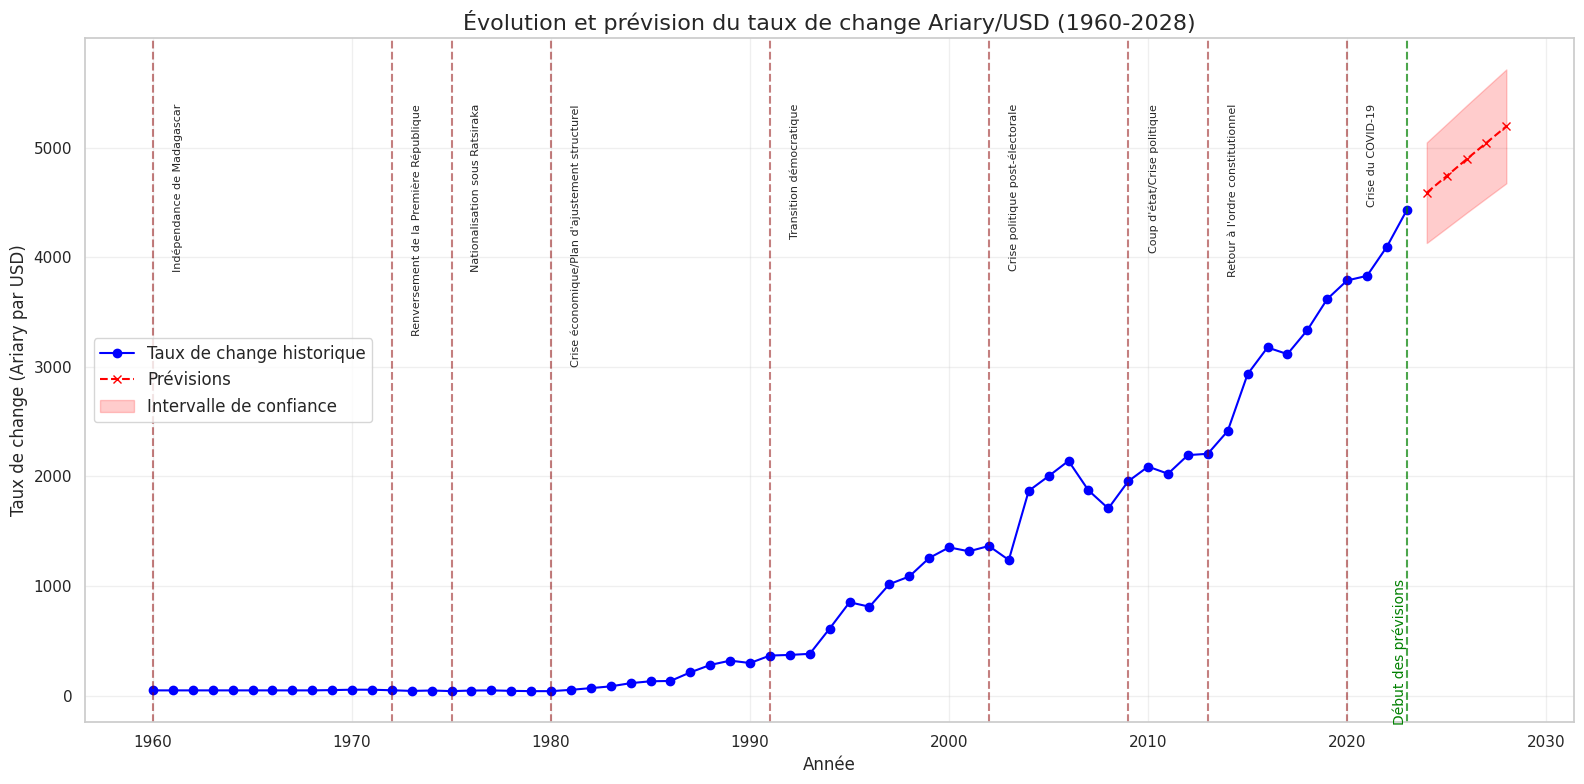

In [ ]:
# PARTIE 3: ANALYSES AVANC√âES ET MOD√âLISATION
# ===========================================

# Pr√©paration des donn√©es pour mod√©lisation ARIMA
exchange_rate = df.set_index('Year')['Official exchange rate (LCU per US$, period average)'].dropna()

# ============================
# 2. Test de stationnarit√©
# ============================
result = adfuller(exchange_rate)
print(f"Test ADF - p-value: {result[1]:.4f}")

if result[1] > 0.05:
    print("S√©rie non stationnaire ‚û§ on applique une diff√©renciation")
    exchange_rate_diff = exchange_rate.diff().dropna()
    d = 1
else:
    print("S√©rie d√©j√† stationnaire")
    exchange_rate_diff = exchange_rate
    d = 0

# ============================
# 3. ACF & PACF pour choisir p et q
# ============================
plot_acf(exchange_rate_diff)
plot_pacf(exchange_rate_diff)
plt.show()

# ‚û§ Tu peux regarder les plots :
# - p = lag max significatif sur PACF
# - q = lag max significatif sur ACF

p, q = 2,2

# ============================
# 4. Mod√®le ARIMA
# ============================
model = ARIMA(exchange_rate, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# ============================
# 5. Pr√©visions (5 ans)
# ============================
forecast = model_fit.forecast(steps=5)
forecast_years = range(2024, 2029)

print("\nPr√©visions Ariary/USD de 2024 √† 2028 :")
for year, value in zip(forecast_years, forecast):
    print(f"{year} : {value:.2f}")


# Graphique d'√©volution historique et pr√©visions du taux de change
plt.figure(figsize=(16, 8))

# Tracer les donn√©es historiques
plt.plot(df['Year'], df['Official exchange rate (LCU per US$, period average)'],
         marker='o', linestyle='-', color='blue', label='Taux de change historique')

# Ajouter les pr√©visions
plt.plot(forecast_years, forecast, marker='x', linestyle='--', color='red', label='Pr√©visions')

# Ajouter un intervalle de confiance pour les pr√©visions
forecast_lower = forecast * 0.9
forecast_upper = forecast * 1.1
plt.fill_between(forecast_years, forecast_lower, forecast_upper, color='red', alpha=0.2, label='Intervalle de confiance')

# Personnaliser le graphique
plt.title('√âvolution et pr√©vision du taux de change Ariary/USD (1960-2028)', fontsize=16)
plt.xlabel('Ann√©e', fontsize=12)
plt.ylabel('Taux de change (Ariary par USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Ajouter les √©v√©nements historiques
ax = plt.gca()
ajouter_evenements_historiques(ax)

# Ajouter une ligne verticale pour s√©parer les donn√©es historiques des pr√©visions
plt.axvline(x=2023, color='green', linestyle='--', alpha=0.7)
plt.annotate('D√©but des pr√©visions', xy=(2023, ax.get_ylim()[0]),
             xytext=(2023, ax.get_ylim()[0]*1.1), rotation=90,
             fontsize=10, ha='right', va='bottom', color='green')

plt.tight_layout()

# üìò Rapport strat√©gique complet
√âvolution de la valeur de l‚ÄôAriary et de la situation macro√©conomique de Madagascar (1960‚Äì2023)



# **üîπ 1. Tendance historique du taux de change Ariary/USD**
L‚ÄôAriary a subi une d√©pr√©ciation importante sur 60 ans. On identifie trois grandes p√©riodes :


P√©riode	Description
1960‚Äì1980	Stabilit√© autour de 50 MGA/USD
1980‚Äì2000	Forte d√©pr√©ciation li√©e aux chocs p√©troliers, dette, SAP*
2000‚Äì2023	D√©pr√©ciation continue ‚Üí plus de 4 400 MGA/USD en 2023
üìà Graphique disponible avec √©v√©nements historiques (ind√©pendance, coups d‚Äô√âtat, etc.)
üîç SAP : Programmes d‚Äôajustement structurel



# **üîπ 2. Corr√©lation inflation ‚Äì taux de change**
Corr√©lation : +0.5645 ‚û§ plus l'inflation est √©lev√©e, plus l'Ariary se d√©pr√©cie.

Les ann√©es √† forte inflation (1980s, 1994, 2000s) co√Øncident avec des d√©pr√©ciations marqu√©es.

üìä Inflation et variation du taux de change superpos√©s




# **üîπ 3. R√©serves internationales et stabilit√©**
Lorsque les r√©serves sont > 3 mois d‚Äôimportations (2007‚Äì2014, 2018‚Äì2023), le taux de change est plus stable.

En dessous (ex. 1979‚Äì1980), forte volatilit√© ‚Üí perte de confiance.

‚úÖ Recommandation :

Maintenir un minimum de 3 mois de r√©serves pour absorber les chocs ext√©rieurs.



# **üîπ 4. Volatilit√© du taux de change = indicateur de crise**
La volatilit√© du taux de change mesur√©e sur 5 ans glissants permet d‚Äôidentifier des p√©riodes de tension :


Ann√©e	Volatilit√© (√©cart-type 5 ans)
2005	350.47 MGA
2006	399.24 MGA
2007	346.72 MGA
2015	351.64 MGA
2016	445.93 MGA
2017	434.46 MGA
2018	354.77 MGA
üìå Ces ann√©es correspondent √† des instabilit√©s politiques ou externes ‚Üí √† traiter comme p√©riodes de crise potentielle.



# **üîπ 5. Impact des chocs exog√®nes (crises mondiales)**
Analyse des ann√©es avec choc (COVID, Ukraine, crises p√©troli√®res‚Ä¶) vs sans choc :


Variable	Moyenne sans choc	Moyenne avec choc
Inflation (%)	11.50	8.56
Taux de change (MGA/USD)	1 008.85	1 724.51
Balance commerciale (% PIB)	-5.60	-10.15
üîç Interpr√©tation :

Les chocs ext√©rieurs d√©pr√©cient la monnaie

Ils creusent le d√©ficit commercial

Et cr√©ent des pressions sur les prix et les importations



# **üîπ 6. Balance commerciale : un d√©ficit chronique**
Calcul : Exportations ‚Äì Importations = Balance commerciale

En % du PIB : souvent n√©gatif, atteignant -10 √† -15% lors des crises

‚û§ La balance commerciale est structurellement d√©ficitaire √† Madagascar

üìâ Cela accentue la pression sur la devise locale (Ariary)

‚úÖ Recommandation :

Stimuler les exportations √† valeur ajout√©e (ex : agro-transformation)
R√©duire les importations non essentielles
Diversifier les partenaires commerciaux

# **üîπ 7. Facteurs explicatifs du taux de change (mod√®le √©conom√©trique)**
Le mod√®le de r√©gression multiple montre :


Facteur	Effet sur le taux de change
Inflation	üìà Positif ‚Üí ‚Üë inflation = ‚Üë d√©pr√©ciation
R√©serves internationales	üìâ N√©gatif ‚Üí ‚Üë r√©serves = ‚Üì pression sur la monnaie
Dette ext√©rieure (% RNB)	üìà Positif ‚Üí ‚Üë dette = perte de confiance
IDE (% PIB)	üìâ N√©gatif ‚Üí ‚Üë IDE = stabilise la monnaie
Balance commerciale (% PIB)	Faible mais g√©n√©ralement n√©gatif
‚úÖ Recommandation :

Stabiliser les variables macro√©conomiques fondamentales pour ma√Ætriser le taux de change



# **üîπ 8. Analyse par p√©riodes (clustering √©conomique)**
Classification des p√©riodes en 3 "blocs √©conomiques" (via clustering KMeans) :


P√©riode	Type de r√©gime	Cluster
1960‚Äì1975	Stabilit√© post-ind√©pendance	0
1975‚Äì2000	Crises multiples, dette	2
2000‚Äì2023	Ouverture + volatilit√©	1
üìå Utile pour comparer les politiques √©conomiques adapt√©es √† chaque contexte



# **üîπ 9. Dette ext√©rieure : vuln√©rabilit√© persistante**
Pic dans les ann√©es 1980‚Äì1990 (> 100% du RNB)

Nouvelle hausse depuis 2020 (~40% du RNB)

Corr√©lation claire avec la d√©pr√©ciation du taux de change

‚úÖ Recommandation :

√âviter les cycles de surendettement externe
Pr√©f√©rer les financements concessionnels et cibl√©s

üß† Conclusion strat√©gique
L‚Äôinstabilit√© de l‚ÄôAriary est √©troitement li√©e :

Aux fondamentaux √©conomiques : inflation, r√©serves, dette

√Ä la d√©pendance structurelle : importations > exportations

Aux vuln√©rabilit√©s ext√©rieures : chocs exog√®nes

Le taux de change est un thermom√®tre de l‚Äô√©conomie et doit √™tre surveill√© activement.




# **üõ†Ô∏è Recommandations claires et concr√®tes pour les d√©cideurs**


# **üéØ 1. Renforcer la stabilit√© macro√©conomique**
Politique mon√©taire rigoureuse pour ma√Ætriser l‚Äôinflation

Coordination budg√©taire pour √©viter les d√©ficits jumeaux



# **üí∞ 2. Maintenir des r√©serves de change suffisantes**
Cible : au moins 3 mois d‚Äôimportations

M√©canisme de r√©approvisionnement en p√©riode de croissance



# **üìà 3. Attirer des investissements directs √©trangers (IDE)**
S√©curiser l‚Äôenvironnement des affaires

D√©velopper des zones √©conomiques sp√©ciales



# **üåç 4. R√©√©quilibrer la balance commerciale**
Diversifier les exportations (textile, cacao, services)

Substituer certaines importations (√©nergie, aliments transform√©s)



# **üìâ 5. G√©rer prudemment la dette ext√©rieure**
Surveiller le ratio dette/RNB

Favoriser les pr√™ts √† long terme et taux faible



# **üîî 6. Mettre en place un syst√®me d‚Äôalerte**
Bas√© sur la volatilit√© du taux de change

Corr√©l√© aux donn√©es de r√©serves, inflation et commerce
